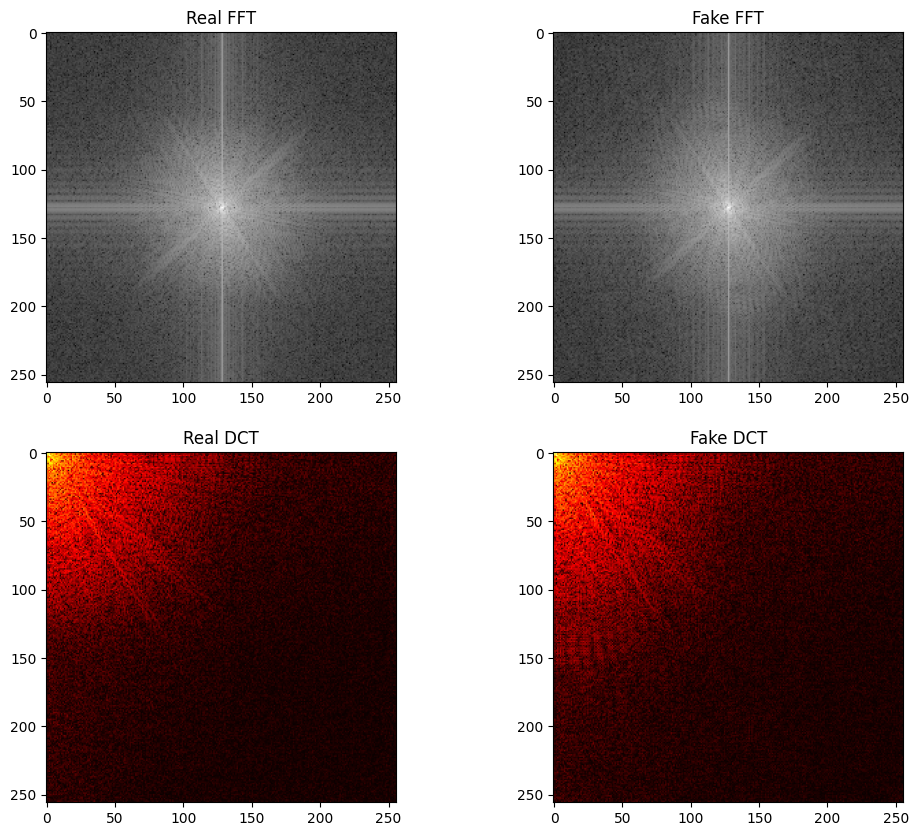

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct

def analyze_frequency(image_path):
    img = cv2.imread(image_path, 0)
    img = cv2.resize(img, (256, 256))
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    
    def get_2d_dct(img):
        return dct(dct(img.T, norm='ortho').T, norm='ortho')
    
    dct_spectrum = np.log(np.abs(get_2d_dct(img.astype(float))) + 1)
    
    return magnitude_spectrum, dct_spectrum

real_img_path = '/home/ghdrnjs/Deepfake/train_data/celeb_df/preprocessed_crops/Celeb-real/id0_0005/1.jpg'
fake_img_path = '/home/ghdrnjs/Deepfake/train_data/celeb_df/preprocessed_crops/Celeb-synthesis/id0_id2_0005/1.jpg'

real_fft, real_dct = analyze_frequency(real_img_path)
fake_fft, fake_dct = analyze_frequency(fake_img_path)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(real_fft, cmap='gray'); axes[0, 0].set_title("Real FFT")
axes[0, 1].imshow(fake_fft, cmap='gray'); axes[0, 1].set_title("Fake FFT")
axes[1, 0].imshow(real_dct, cmap='hot');  axes[1, 0].set_title("Real DCT")
axes[1, 1].imshow(fake_dct, cmap='hot');  axes[1, 1].set_title("Fake DCT")
plt.show()

Text(0.5, 1.0, 'FFT Difference (Magnified)')

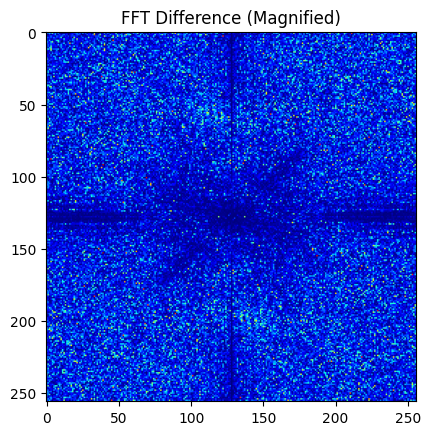

In [5]:
diff_fft = np.abs(real_fft - fake_fft)
diff_dct = np.abs(real_dct - fake_dct)

plt.imshow(diff_fft * 10, cmap='jet')
plt.title("FFT Difference (Magnified)")

In [ ]:
from insightface.app import FaceAnalysis
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

VIDEO_PATH = "/home/ghdrnjs/Deepfake/train_data/Dataset/WildDeepfake/deepfake_in_the_wild/real_train/36/real/67/1783.png"

%matplotlib inline

def align_face(img, kps, output_size=(224, 224)):
    """
    5개 랜드마크를 기준으로 얼굴을 수평 정렬하는 함수
    """
    left_eye = kps[0]
    right_eye = kps[1]
    eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    M = cv2.getRotationMatrix2D(eye_center, angle, scale=1.0)

    h, w = img.shape[:2]
    aligned_img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)

    return aligned_img

def show_separate_plots(video_path):
    app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(128, 128)) 

    cap = cv2.VideoCapture(video_path)
    ret, frame_bgr = cap.read()
    cap.release()
    
    if not ret:
        print("동영상을 읽을 수 없습니다.")
        return
    
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    faces = app.get(frame_rgb)
    
    if not faces:
        print("얼굴을 찾지 못했습니다.")
        return

    face = faces[0]
    bbox = face.bbox.astype(int)
    x1, y1, x2, y2 = bbox

    plt.figure(figsize=(10, 8))
    img_with_box = frame_rgb.copy()
    cv2.rectangle(img_with_box, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    plt.imshow(img_with_box)
    plt.title(f"1. Detection Box (Original Resolution: {frame_rgb.shape[1]}x{frame_rgb.shape[0]})")
    plt.axis('off')
    plt.show() 

    h, w, _ = frame_rgb.shape
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    img_crop = frame_rgb[y1:y2, x1:x2]

    plt.figure(figsize=(6, 6))
    plt.imshow(img_crop)
    plt.title(f"2. Cropped Face (Resolution: {img_crop.shape[1]}x{img_crop.shape[0]})")
    plt.axis('off')
    plt.show()

    landmarks = face.kps.astype(int)
    img_with_landmarks = frame_rgb.copy()
    
    for lm in landmarks:
        cv2.circle(img_with_landmarks, (lm[0], lm[1]), 3, (255, 0, 0), -1)
        
    plt.figure(figsize=(10, 8))
    plt.imshow(img_with_landmarks)
    plt.title(f"3. 5-Point Landmarks (KPS)")
    plt.axis('off')
    plt.show()

    aligned_img = align_face(frame_rgb, face.kps)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(aligned_img)
    plt.title("4. Horizontally Aligned Face")
    plt.axis('off')
    plt.show()

show_separate_plots(VIDEO_PATH)